# Analyzing Influenza Trends Using Multiple Data Sources
---
## Research Questions
**1. What are the key trends in influenza outbreak over the years in the dataset?**
- This question aims to identify patterns or trends in the influenza outbreak data, such as peak times of the year or increasing/decreasing trends over the years.

**2. How does the severity of the outbreak vary by geographic regions included in the dataset?**
- This explores geographical differences in influenza severity, which can be crucial for regional healthcare planning.

**3. Can we predict future influenza outbreaks based on historical data?**
- This question seeks to apply statistical or machine learning methods to predict future outbreaks, enhancing preparedness and response.

Check Results section for detail process and answers.

---
## Challenge Goals
- Work with messy MATLAB structured data
- Integrate multiple flu datasets
- Apply statistical analysis and ARIMA forecasting
- Visualize geographic outbreak differences
- ......

## Conduct

In [98]:
your_name = "Zeyin Feng"
sources = [
    "https://www.earthdatascience.org/courses/intro-to-earth-data-science/file-formats/use-text-files/format-text-with-pandas/",
    "https://www.youtube.com/watch?v=TEBsiR6hImo",
    "https://archive.ics.uci.edu/dataset/861/influenza+outbreak+event+prediction+via+twitter",
    "https://gis.cdc.gov/grasp/fluview/fluportaldashboard.html",
    "Lecture from Data Frames",
    "https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/",
    "https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html",
    "https://www.w3schools.com/python/ref_func_isinstance.asp"
]

## Data Setting

### Datasets Used:

1. **ILINet Dataset**: Provides weekly reports of Influenza-Like Illness (ILI) from sentinel providers, essential for tracking flu trends over time.

2. **ICL_NREVSS_Clinical_Labs Dataset**: Includes data from clinical laboratories detailing the number of specimens tested and the results, helping identify the prevalence of different flu strains.

3. **ICL_NREVSS_Public_Health_Labs Dataset**: Similar to the Clinical Labs dataset but focuses on data collected from public health labs, offering insights into broader community health impacts.

4. **influenza_outbreak_dataset.mat**: Contains historical data on influenza outbreaks. This MATLAB file likely includes structured data such as matrices or cell arrays, which can provide detailed information on cases, geographic locations, and time frames.
- *'flu_locations': a list of states.*
- *'flu_keywords': keyword list.*
- *'flu_X_': input data for all the locations and all the weeks.*
- *'flu_Y_': output data for all the locations and all the weeks.*

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import numpy as np
import seaborn as sns
import geopandas as gpd
from scipy.io import loadmat
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

## Processing with .mat file

In [100]:
mat_data = loadmat(r"influenza_outbreak_dataset.mat")
print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'flu_X_tr', 'flu_Y_tr', 'flu_X_te', 'flu_Y_te', 'flu_locs', 'flu_keywords'])


In [101]:
# Test for change df with array into the string and number
test_df = pd.DataFrame({
  'Location': [np.array(['wyoming']), np.array(['colorado']), np.array(['nebraska']), np.array([np.nan])],
  'Severity': [[[0], [1]], [[1], [1]], [[0], [0]], [[1], [0]]]
})

'''
expected_df = pd.DataFrame({
  'Location': ['wyoming', 'colorado', 'nebraska', 'NaN'],
  'Severity': [0.5, 1, 0, 0.5]
})
'''

# Change location from Array to String
test_df['Location'] = test_df['Location'].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x)
# Calculating the mean of each array
test_df['Severity'] = test_df['Severity'].apply(lambda x: np.mean([int(num[0]) for num in x]))

print(test_df.head())

   Location  Severity
0   wyoming       0.5
1  colorado       1.0
2  nebraska       0.0
3       NaN       0.5


In [102]:
# Extract geographic locations and severity data
locations = mat_data['flu_locs'].ravel()
severity = mat_data['flu_Y_tr'].ravel()

# Now create the DataFrame
df = pd.DataFrame({
  'Location': locations,
  'Severity': severity
})

# Change location from Array to String
df['Location'] = df['Location'].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x)

# Calculating the mean of each array
df['Severity'] = df['Severity'].apply(lambda x: np.mean([int(num[0]) for num in x]))

df.head()

,Location,Severity
0,wyoming,0.044749
1,colorado,0.047489
2,nebraska,0.070320
3,washington,0.012785
4,rhode island,0.019178


## Process the CSV data

In [103]:
# Load the datasets
ilinet_data = pd.read_csv('ILINet.csv', skiprows=1)
clinical_labs_data = pd.read_csv('ICL_NREVSS_Clinical_Labs.csv', skiprows=1)
public_health_labs_data = pd.read_csv('ICL_NREVSS_Public_Health_Labs.csv', skiprows=1)

In [104]:
# Test for combining two df by 'WEEK' and 'YEAR', make 'DATE' column as well
df1 = pd.DataFrame({
  'YEAR': [2023, 2023],
  'WEEK': [40, 41],
  'DATA1': [100, 200]
})

df2 = pd.DataFrame({
  'YEAR': [2023, 2023],
  'WEEK': [40, 41],
  'DATA2': [300, 400]
})

expected_df = pd.DataFrame({
  'YEAR': [2023, 2023],
  'WEEK': [40, 41],
  'DATA1': [100, 200],
  'DATE': [pd.Timestamp('2023-10-02'), pd.Timestamp('2023-10-09')],
  'DATA2': [300, 400]
})

df1['DATE'] = pd.to_datetime(df1['YEAR'].astype(str) + ' ' +
                            df1['WEEK'].astype(str) + ' 1', format='%Y %U %w')

merged_data = pd.merge(df1, df2, on=['YEAR', 'WEEK'], how='inner')

print(merged_data)

   YEAR  WEEK  DATA1       DATE  DATA2
0  2023    40    100 2023-10-02    300
1  2023    41    200 2023-10-09    400


In [105]:
# Preprocess
# Assuming 'YEAR' and 'WEEK' are columns in your DataFrame
ilinet_data['DATE'] = pd.to_datetime(ilinet_data['YEAR'].astype(str) + ' ' +
                                    ilinet_data['WEEK'].astype(str) + ' 1', format='%Y %U %w')
clinical_labs_data['DATE'] = pd.to_datetime(clinical_labs_data['YEAR'].astype(str) + ' ' +
                                clinical_labs_data['WEEK'].astype(str) + ' 1', format='%Y %U %w')
public_health_labs_data['DATE'] = pd.to_datetime(public_health_labs_data['YEAR'].astype(str)
                      + ' ' + public_health_labs_data['WEEK'].astype(str) + ' 1', format='%Y %U %w')

# Merge the datasets on 'YEAR' and 'WEEK'
merged_data = pd.merge(ilinet_data, clinical_labs_data, on=['YEAR', 'WEEK'], how='inner')
merged_data = pd.merge(merged_data, public_health_labs_data, on=['YEAR', 'WEEK'], how='inner')

In [106]:
merged_data.head()

,REGION TYPE_x,REGION_x,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,...,TOTAL SPECIMENS_y,A (2009 H1N1),A (H3),A (Subtyping not Performed),B,BVic,BYam,H3N2v,A (H5),DATE
0,National,X,2023,40,2.27908,2.26141,13519,13441,X,19001,...,3064,176,16,10,3,48,0,0,0,2023-10-02
1,National,X,2023,41,2.33755,2.31454,14419,13964,X,18593,...,3067,213,22,12,5,68,0,0,0,2023-10-09
2,National,X,2023,42,2.52242,2.51633,15704,14454,X,20290,...,3416,276,26,34,12,73,0,0,0,2023-10-16
3,National,X,2023,43,2.71275,2.68605,16986,15480,X,22514,...,2934,240,36,48,14,68,0,0,0,2023-10-23
4,National,X,2023,44,2.94538,2.91431,17793,16585,X,24797,...,3172,292,41,63,13,90,0,0,0,2023-10-30


## Results
# 1. Trends in influenza outbreak over the years

In [107]:
def ili_metrics(df, date_col="DATE", value_col="% WEIGHTED ILI", baseline_weeks=3):
    """
    Compute key epidemiological indicators for weekly ILI data:
      - peak_value / peak_date: maximum ILI level and when it occurred
      - baseline: early-season baseline using first `baseline_weeks` weeks
      - rise_rate_per_week: rate of increase from baseline to seasonal peak
      - auc: area under the curve (proxy for overall seasonal intensity)

    Assumptions:
      - Data contains weekly time-series
      - Data is already cleaned and sorted by date
    """

    # Keep only date and value columns, sort by date, reset index
    d = df[[date_col, value_col]].dropna().sort_values(date_col).reset_index(drop=True)

    # Ensure we have enough data to compute metrics
    if d.empty or len(d) < 2:
        raise ValueError("Not enough data to compute ILI metrics.")

    # Peak value and timing
    peak_idx = d[value_col].idxmax()
    peak_value = float(d.loc[peak_idx, value_col])
    peak_date = pd.to_datetime(d.loc[peak_idx, date_col])

    # Baseline: average of first baseline_weeks
    bw = max(1, min(baseline_weeks, len(d)))  # avoid out-of-range errors
    baseline = float(d.loc[:bw-1, value_col].mean())

    # Weekly rise rate: (peak - baseline) / weeks_to_peak
    weeks_to_peak = max(1, peak_idx)  # avoid division by zero
    rise_rate_per_week = (peak_value - baseline) / weeks_to_peak

    # Area under the curve (AUC) as intensity proxy
    import numpy as np
    auc = float(np.trapz(y=d[value_col].values, x=np.arange(len(d))))

    return {
        "peak_value": peak_value,
        "peak_date": peak_date,
        "baseline": baseline,
        "rise_rate_per_week": rise_rate_per_week,
        "auc": auc
    }

In [108]:
# Compute seasonal metrics for the excerpt dataset
metrics = ili_metrics(ilinet_data, date_col="DATE", value_col="% WEIGHTED ILI")
print("ILI Seasonal Metrics:", metrics)

ILI Seasonal Metrics: {'peak_value': 6.7962, 'peak_date': Timestamp('2023-12-25 00:00:00'), 'baseline': 2.379683333333333, 'rise_rate_per_week': 0.36804305555555555, 'auc': 149.82191500000002}


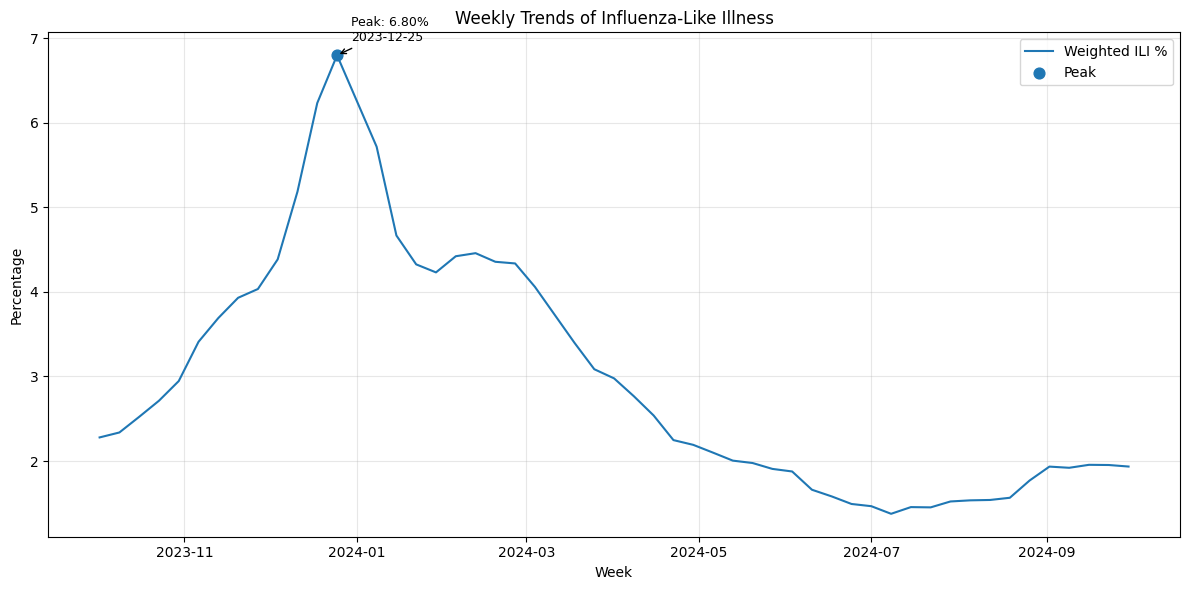

In [109]:
# Weekly trends of ILI
plt.figure(figsize=(12, 6))
plt.plot(merged_data['DATE'], merged_data['% WEIGHTED ILI'], label='Weighted ILI %')

# Annotate seasonal peak
plt.scatter([metrics["peak_date"]], [metrics["peak_value"]], s=60, label="Peak")
plt.annotate(
    f"Peak: {metrics['peak_value']:.2f}%\n{metrics['peak_date'].date()}",
    xy=(metrics["peak_date"], metrics["peak_value"]),
    xytext=(10, 10),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1),
    fontsize=9
)
plt.title('Weekly Trends of Influenza-Like Illness')
plt.xlabel('Week')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

1. **Seasonal Peak**  
- ILI levels rise steadily through fall and reach a clear peak in late December (≈6.8%), consistent with typical winter influenza seasonality driven by colder, drier conditions and increased indoor gathering.

2. **Post-Peak Decline**  
- Following the peak, influenza activity declines through late winter and spring, reaching its lowest levels around mid-summer (≈1.4–1.6%).

3. **Summer Low Plateau**  
- A sustained low plateau is observed during June–August, indicating minimal flu transmission during warmer months.

4. **Early-Fall Rebound**
- Beginning in late August, a gradual uptick appears, signaling the onset of the next influenza season.

# 2. Geographic Average Severity

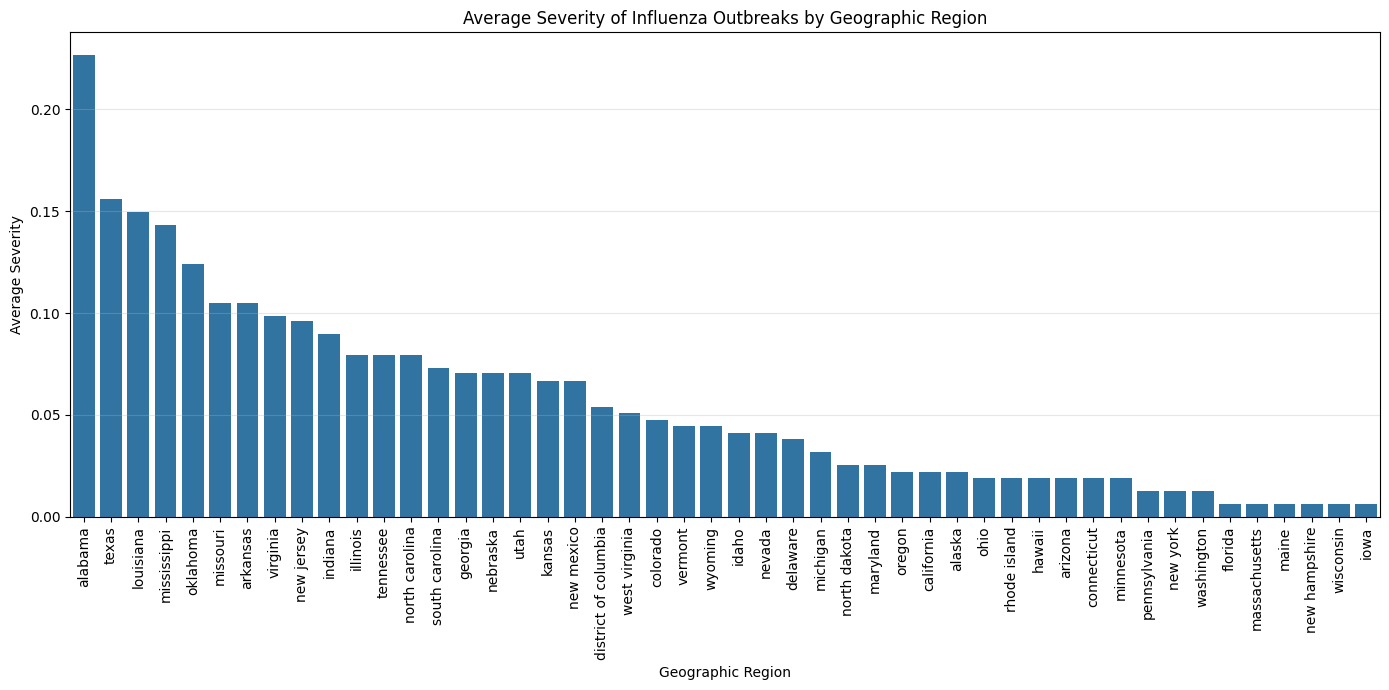

In [110]:
# Plotting the severity scores by location
plt.figure(figsize=(14, 7))
_order = df.sort_values('Severity', ascending=False)['Location']
sns.barplot(x='Location', y='Severity', data=df, order=_order)
plt.xticks(rotation=90)
plt.title('Average Severity of Influenza Outbreaks by Geographic Region')
plt.xlabel('Geographic Region')
plt.ylabel('Average Severity')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


1. **Higher‑severity regions**: States such as **Alabama, Texas, Louisiana, Mississippi**, and **Oklahoma** exhibit the highest average influenza severity, indicating stronger seasonal impact or more intensive outbreak cycles in these areas.

2. **Lower‑severity regions**: States including **Iowa, Wisconsin, New Hampshire, Maine**, and **Massachusetts** show the lowest severity levels, reflecting milder influenza activity over the period observed.

3. **Interpretation**: These regional differences may be influenced by factors such as **climate patterns** (warmer southern states often see more sustained transmission), **population density** and **mobility**, **healthcare resource availability**, and **reporting variations** across states.

# 3. Future Prediction

In [111]:
merged_data['DATE'] = pd.to_datetime(merged_data['DATE'])
merged_data.set_index('DATE', inplace=True)
ili_data = merged_data['% WEIGHTED ILI'].resample('W').mean()
ili_data = ili_data.interpolate(method='linear')
# Splitting the Data
train_data = ili_data[:int(0.8 * len(ili_data))]
test_data = ili_data[int(0.8 * len(ili_data)):]

In [112]:


'''
Finding best pdq value using auto_arima
p is the number of autoregressive terms,
d is the number of nonseasonal differences needed for stationarity, and
q is the number of lagged forecast errors in the prediction equation.
'''
model = auto_arima(train_data, start_p=1, start_q=1,
  test='adf',             # use adftest to find optimal 'd'
  max_p=3, max_q=3,       # maximum p and q
  m=1,                    # frequency of series
  d=None,                 # let model determine 'd'
  seasonal=False,         # No Seasonality
  start_P=0,
  D=0,
  trace=True,
  error_action='ignore',
  suppress_warnings=True,
  stepwise=True)

print(model.summary())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pytho

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=15.681, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=17.224, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=17.285, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=13.681, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.415 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   42
Model:               SARIMAX(0, 2, 0)   Log Likelihood                  -5.840
Date:                Tue, 04 Nov 2025   AIC                             13.681
Time:                        13:10:35   BIC                             15.370
Sample:                    10-08-2023   HQIC                            14.291
                         - 07-21-2024                                         
Covariance

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [113]:

# Fit the model on the training data
model = ARIMA(train_data, order=(0, 2, 0))
fitted_model = model.fit()
# Forecast
forecast = fitted_model.get_forecast(steps=len(test_data))
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

In [114]:
# Calculate prediction errors
errors = test_data - mean_forecast
mse = np.mean(np.square(errors)) # Mean Squared Error
mae = np.mean(np.abs(errors)) # Mean Absolute Error
rmse = np.sqrt(mse) # Root Mean Squared Error
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 0.04709384418065066
Mean Absolute Error: 0.195205455419504
Root Mean Squared Error: 0.2170111614195239


**Model Evaluation Summary**

- **MSE ≈ 0.047**, **MAE ≈ 0.195**, **RMSE ≈ 0.217**. Lower values indicate better fit.
- The model captures the broad seasonal direction, but **uncertainty remains high**; adding explicit seasonal components and additional features would likely improve accuracy.

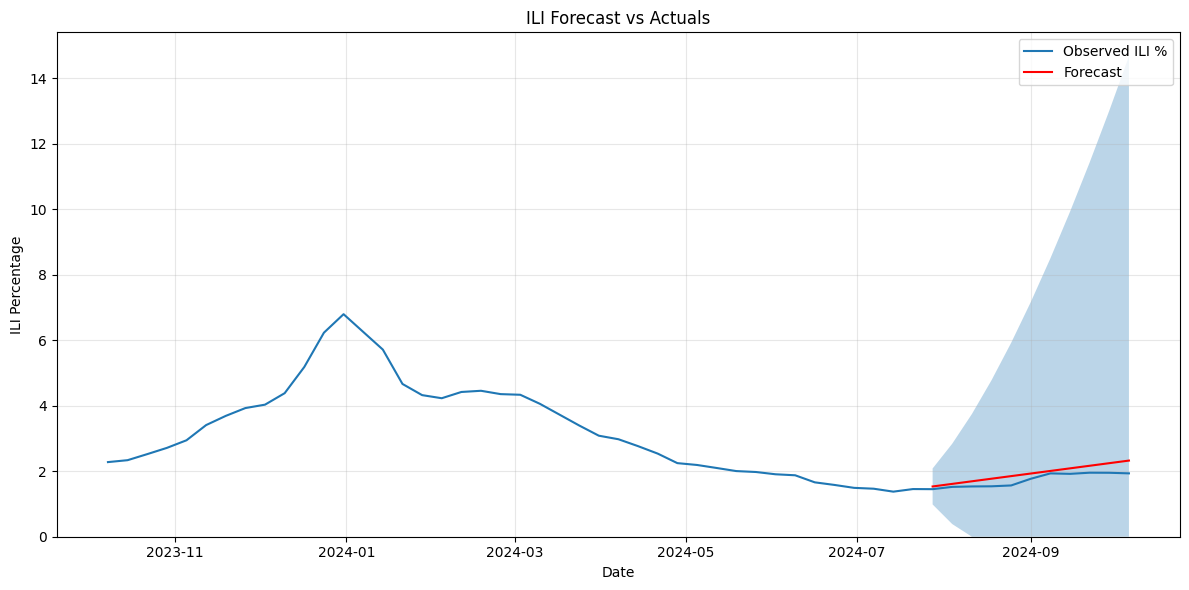

In [115]:
# Visualization
plt.figure(figsize=(12, 6))
plt.plot(ili_data.index, ili_data, label='Observed ILI %')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast', color='red')

# Clip confidence interval to non-negative since ILI is a percentage
_lower = np.clip(confidence_intervals.iloc[:, 0].values, 0, None)
_upper = np.clip(confidence_intervals.iloc[:, 1].values, 0, None)
plt.fill_between(mean_forecast.index, _lower, _upper, alpha=0.3)
plt.title('ILI Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('ILI Percentage')
plt.legend()
plt.ylim(bottom=0)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


1. Smooth Transition at Forecast Start:
- The forecast begins immediately after the final observed data point in late summer. At the transition point, the predicted values align closely with the observed trend, indicating that the model accurately captures the seasonal decline and stabilization during the summer period.

2. Expected Seasonal Rebound:
- As the model projects into early fall, the forecast shows a gradual upward trend, consistent with typical influenza seasonality where activity starts to increase as cooler months approach.

3. Increasing Uncertainty Over Time：
- The confidence interval widens notably as the prediction horizon extends, reflecting greater uncertainty in longer-range forecasts. This behavior is expected for seasonal infectious disease models, and highlights the natural difficulty of precisely estimating influenza patterns several months ahead.

## Implications and Limitations

### Who Might Benefit from the Analysis:

- Public Health Officials: This analysis provides valuable insights that can help public health officials prioritize
resources, design targeted vaccination campaigns, and implement more effective public health interventions in
regions identified as having higher severity.

- Healthcare Providers: Understanding which regions are more likely to experience severe outbreaks can help hospitals
and clinics prepare for surges in patient numbers, ensuring adequate staffing and medical supplies.

- Researchers and Epidemiologists: The data-driven approach and the ability to predict future trends can support
further research into influenza transmission patterns, contributing to better disease modeling and forecasting efforts.

### Impact of the Data Setting on Results:

- Data Quality and Completeness: The quality and completeness of the data significantly impact the results. Regions
with more robust data collection practices may appear to have higher or lower severity simply due to better
reporting, rather than actual differences in outbreak intensity.

- Seasonal and Environmental Factors: The data is inherently influenced by seasonal and environmental factors, which
can vary widely across different geographic regions. This can lead to overemphasis on trends that are specific to
certain climates or seasons, potentially skewing the analysis.

- Historical Data Relevance: The relevance of historical data to future predictions depends on the assumption that past
patterns will continue. However, changes in virus strains, public health interventions, and population behavior could
disrupt these patterns, impacting the accuracy of predictions.

### Limitations of the Analysis:
1. Data Representation and Bias:
- The analysis relies on data that may not be uniformly reported across all regions. Regions with better data
collection systems might be overrepresented, while those with limited reporting might be underrepresented or
missed entirely.
2. Prediction Model Limitations:
- The predictive model used for forecasting future outbreaks is based on historical data and assumes that past
trends will continue. It may not account for unforeseen factors like new virus strains, changes in public health
policies, or shifts in population immunity.
3. Geographic and Climatic Variability:
- The analysis does not fully account for the wide variability in geographic and climatic conditions across different
regions, which can influence the spread and severity of influenza. Regions with similar severity levels in the data
might have vastly different underlying factors driving these trends.